In [32]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm.auto import tqdm

print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else "cpu"

2.2.2+cu121


In [4]:
data_path = Path('datasets')
image_path = data_path / 'pizza_steak_sushi'

In [5]:
import os

def walk_through_dir(dir_path: Path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} in {dirpath}')

walk_through_dir(image_path)

There are 2 directories and 0 in datasets/pizza_steak_sushi
There are 3 directories and 0 in datasets/pizza_steak_sushi/test
There are 0 directories and 25 in datasets/pizza_steak_sushi/test/pizza
There are 0 directories and 31 in datasets/pizza_steak_sushi/test/sushi
There are 0 directories and 19 in datasets/pizza_steak_sushi/test/steak
There are 3 directories and 0 in datasets/pizza_steak_sushi/train
There are 0 directories and 78 in datasets/pizza_steak_sushi/train/pizza
There are 0 directories and 72 in datasets/pizza_steak_sushi/train/sushi
There are 0 directories and 75 in datasets/pizza_steak_sushi/train/steak


In [7]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('datasets/pizza_steak_sushi/train'),
 PosixPath('datasets/pizza_steak_sushi/test'))

Image Path: datasets/pizza_steak_sushi/test/pizza/2871261.jpg
Image class: pizza
Image HxW: 384x512
Image Shape: (384, 512, 3)


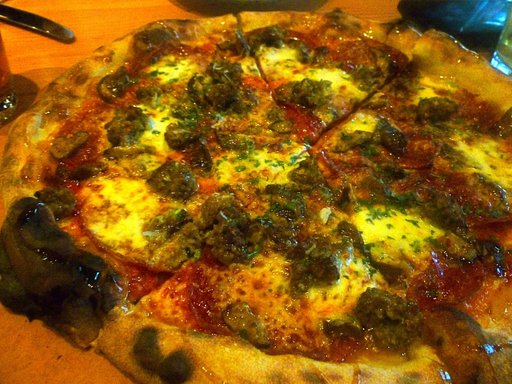

In [30]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
image_class

image = Image.open(random_image_path)
print(f'Image Path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image HxW: {image.height}x{image.width}')
print(f'Image Shape: {np.array(image).shape}')
image

In [37]:
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [40]:
image_tensor = data_transforms(image)
image_tensor.shape

torch.Size([3, 64, 64])

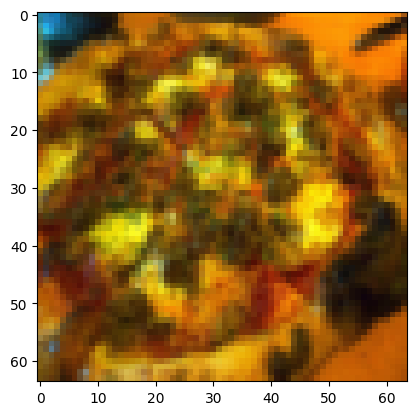

In [46]:
# C H W -> H W C
image_tensor_c_last = image_tensor.permute(1, 2, 0)
plt.imshow(image_tensor_c_last)

### Loading dataset using `ImageFolder`

In [47]:
train_data = datasets.ImageFolder(
    train_dir, 
    transform=data_transforms,  # transforms for the data
    target_transform=None,      # transforms for the lables
)

test_data = datasets.ImageFolder(
    test_dir, 
    transform=data_transforms,  # transforms for the data
    target_transform=None,      # transforms for the lables
)

In [49]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: datasets/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: datasets/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [51]:
class_names = train_data.classes

Text(0.5, 1.0, 'pizza')

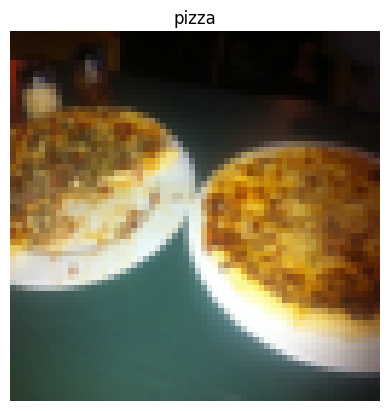

In [53]:
image, label = train_data[0]
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label])

In [61]:
import os
os.cpu_count()

16

In [62]:
train_dataloader = DataLoader(
    train_data, 
    batch_size=32, 
    shuffle=True, 
    num_workers=os.cpu_count(),
    prefetch_factor=2
)

test_dataloader = DataLoader(
    test_data, 
    batch_size=32, 
    shuffle=False
)

In [67]:
img_batch, label_batch = next(iter(train_dataloader))

torch.Size([32, 3, 64, 64]) torch.Size([32])


Text(0.5, 1.0, 'steak')

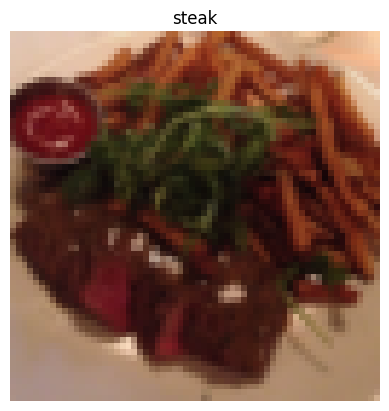

In [68]:
print(img_batch.shape, label_batch.shape)
plt.imshow(img_batch[0].permute(1, 2, 0))
plt.axis('off')
plt.title(class_names[label_batch[0]])

### Loading image data with a custom `Dataset`

In [72]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from typing import Tuple, Dict, List, Callable
from pathlib import Path
import matplotlib.pyplot as plt

In [53]:
class CustomImageFolderDataset(Dataset):
    def __init__(self, path:Path, transforms: List[Callable]=None):
        self.path = path
        self.all_image_paths = sorted(list(self.path.glob('*/*')))
        self.class_list = self.get_classes_list()
        self.__classname_to_idx = self.__get_classes_dict()
        self.transforms = transforms
    
    def get_classes_list(self):
        class_dirs = self.path.glob('*')
        return [x.stem for x in sorted(list(class_dirs))]
    
    def __get_classes_dict(self):
        class_dirs = self.path.glob('*')
        class_dict = {}
        for i, x in enumerate(sorted(list(class_dirs))):
            class_dict[str(x.stem )] = i
        return class_dict
    
    def __len__ (self):
        return len(self.all_image_paths)
    
    def __getitem__(self, index):
        image = self.all_image_paths[index]
        label = self.__classname_to_idx[image.parent.stem]
        image = Image.open(image)
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, label

In [130]:
db_path = Path('datasets/pizza_steak_sushi')
train_path = db_path / 'train'

db_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(), 
])
db = CustomImageFolderDataset(train_path, transforms=db_transforms)
# db.get_classes_dict()

len(db.all_image_paths)

225

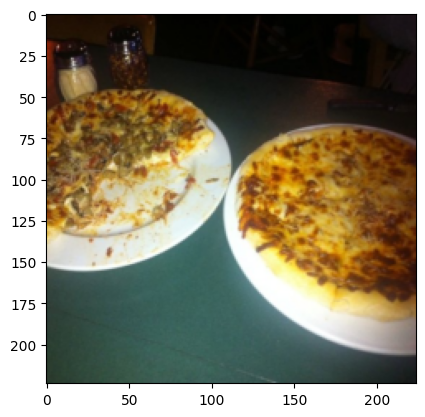

In [133]:
plt.imshow(next(iter(db))[0].permute(1, 2, 0))

In [63]:
data_loader = DataLoader(db, batch_size=32, shuffle=True, num_workers=1)

next(iter(data_loader))[0].shape

torch.Size([32, 3, 224, 224])